## Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Configure Data Loader
Step 9. Define Optimizers
Step 10. Training
```
---

### Step 1. Import Libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

### Step 2. Initial setting

In [2]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [3]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [4]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

### Step 3. Define Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

### Step 4. Define Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True), # difference relu and relu(inplace=true)
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

### Step 5. Define Loss Function

In [7]:
adversarial_loss = torch.nn.BCELoss()

In [8]:
generator = Generator()
discriminator = Discriminator()

### Step 6. Initialize generator and Discriminator

In [9]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Step 7. GPU Setting

In [10]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

### Step 8. Configure Data Loader

In [11]:
import pandas as pd
from torch.utils.data import Dataset

In [12]:
class DatasetMNIST(Dataset): # inherit abstract class - 'Dataset'

    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image ad ndarray type (H, W, C)
        # be carefull for converting dtype to np.uint8 (Unsigned integer (0 to 255))
        # in this example, We use ToTensor(), so we define the numpy array like (H, W, C)

        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [19]:
!unzip /content/MNIST_CSV.zip

Archive:  /content/MNIST_CSV.zip
  inflating: generate_mnist_csv.py   
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         
  inflating: readme.md               


> TEST CODE : Read CSV file

In [20]:
train = pd.read_csv('/content/mnist_train.csv')

In [ ]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> TEST CODE : Construct image from csv file

In [21]:
for index in range(1, 6): # N : 5 (Number of Image)
    temp_image = train.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
    temp_label = train.iloc[index, 0]
    print('Shape of Image : ',temp_image.shape)
    print('label : ', temp_label)

Shape of Image :  (28, 28, 1)
label :  4
Shape of Image :  (28, 28, 1)
label :  1
Shape of Image :  (28, 28, 1)
label :  9
Shape of Image :  (28, 28, 1)
label :  2
Shape of Image :  (28, 28, 1)
label :  1


> TEST CODE : transform from table data to image data with basic preprocessing

In [22]:
dataset = DatasetMNIST(file_path='/content/mnist_train.csv',
                       transform=transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]
                       ))

In [23]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [24]:
temp_img.size() # before ToTensor() : (28,28,1), after : (1,28,28)

torch.Size([1, 28, 28])

In [25]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

> TEST CODE : Define dataloader that can load image by batch

In [26]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

### Step 9. Define optimizers

In [28]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [29]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

### Step 10. Training

In [30]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [31]:
from tqdm.notebook import tqdm

In [32]:
# Visualize result
import matplotlib.pyplot as plt

  0%|          | 0/938 [00:00<?, ?it/s]

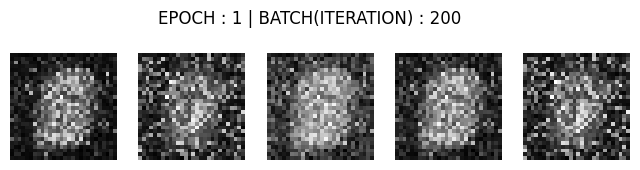

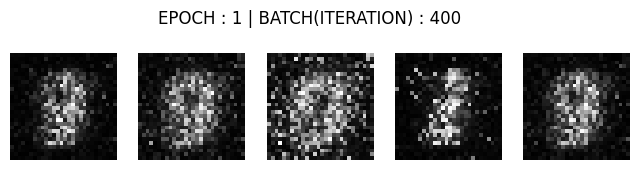

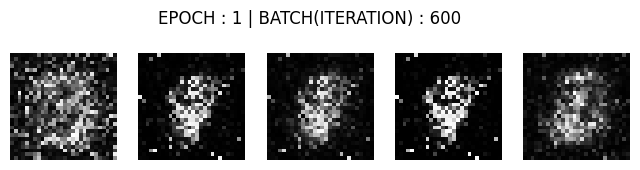

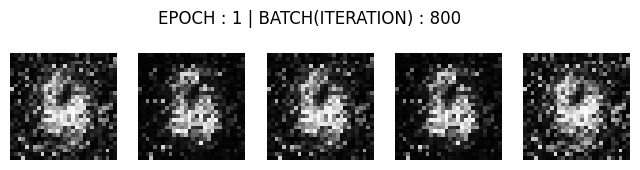

[Epoch: 1/10] [Batch: 938/938] [D loss: 0.703866] [G loss: 1.977896]


  0%|          | 0/938 [00:00<?, ?it/s]

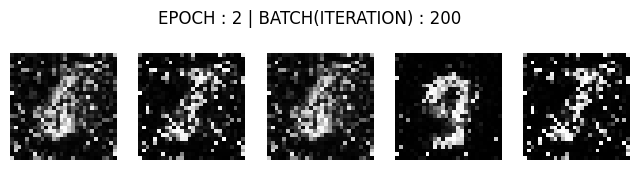

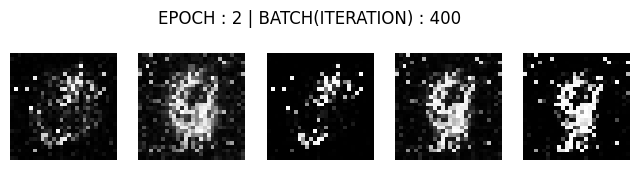

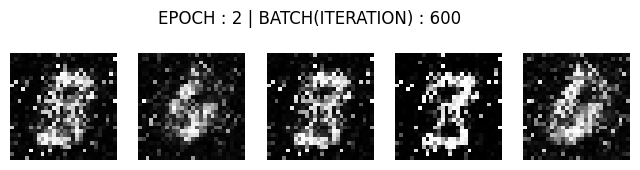

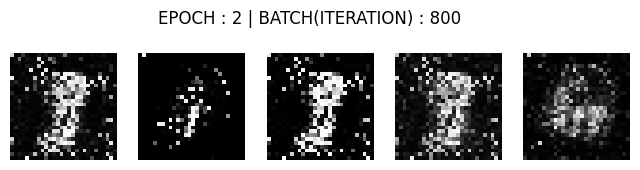

[Epoch: 2/10] [Batch: 938/938] [D loss: 0.304864] [G loss: 1.985859]


  0%|          | 0/938 [00:00<?, ?it/s]

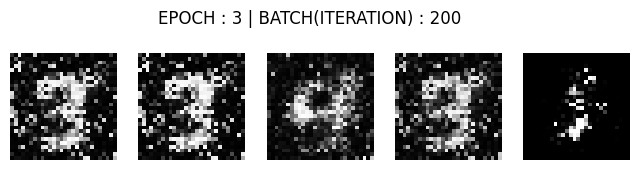

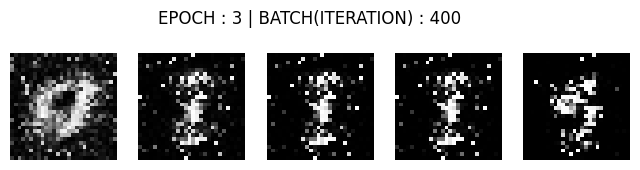

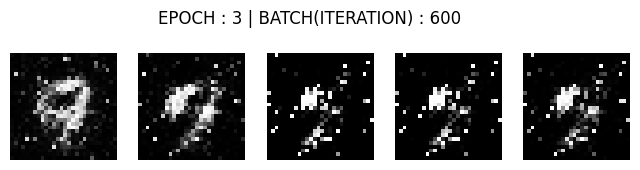

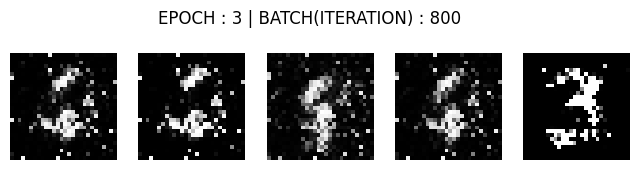

[Epoch: 3/10] [Batch: 938/938] [D loss: 0.190433] [G loss: 2.571064]


  0%|          | 0/938 [00:00<?, ?it/s]

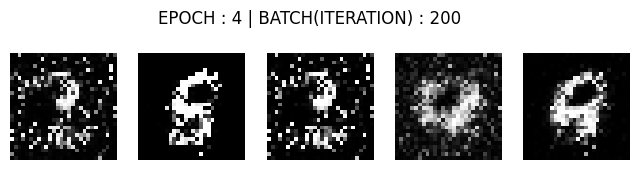

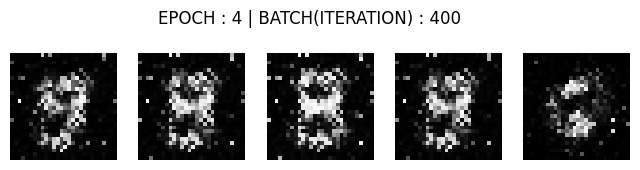

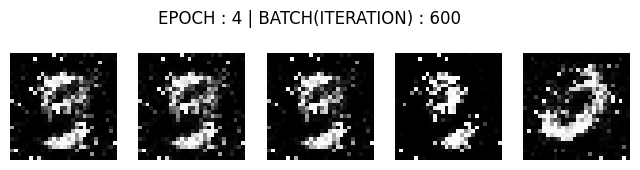

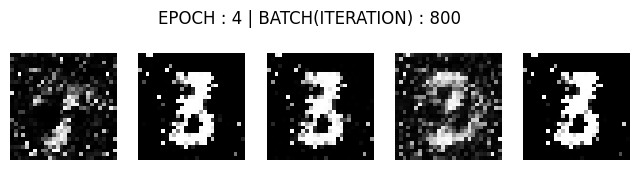

[Epoch: 4/10] [Batch: 938/938] [D loss: 0.106401] [G loss: 2.577620]


  0%|          | 0/938 [00:00<?, ?it/s]

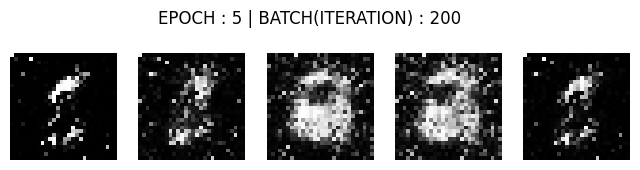

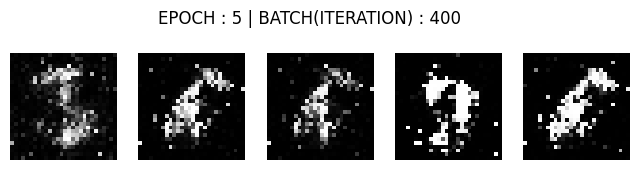

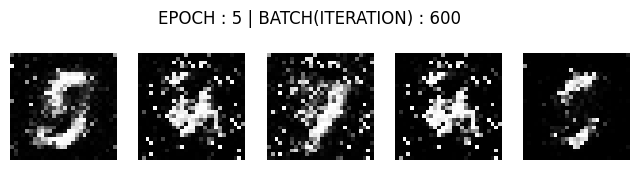

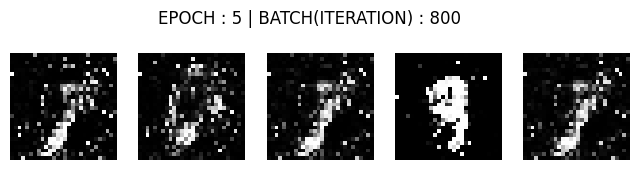

[Epoch: 5/10] [Batch: 938/938] [D loss: 0.225115] [G loss: 1.762024]


  0%|          | 0/938 [00:00<?, ?it/s]

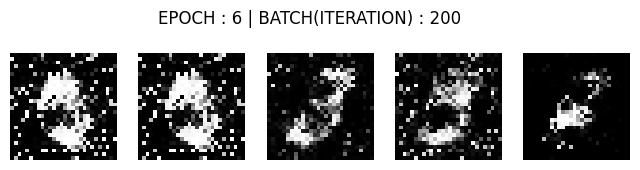

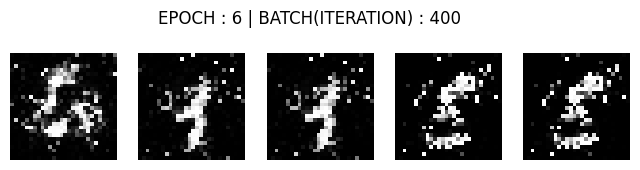

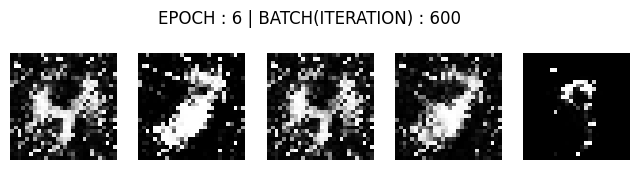

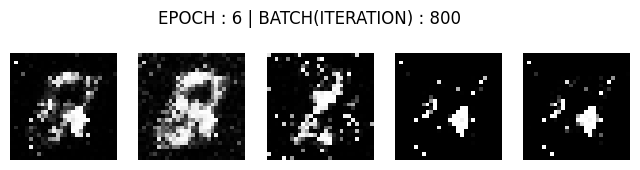

[Epoch: 6/10] [Batch: 938/938] [D loss: 0.302924] [G loss: 1.846093]


  0%|          | 0/938 [00:00<?, ?it/s]

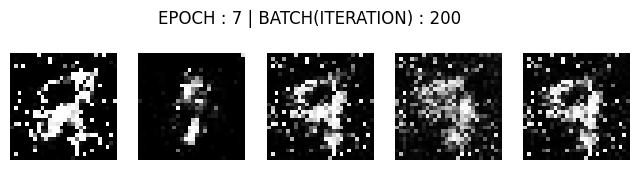

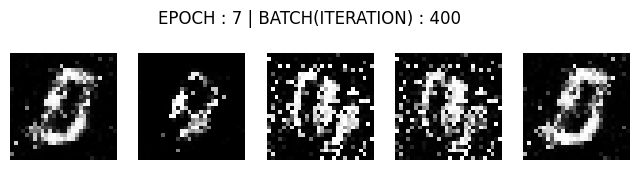

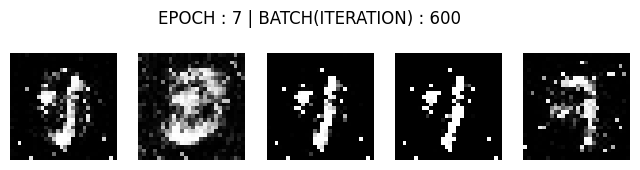

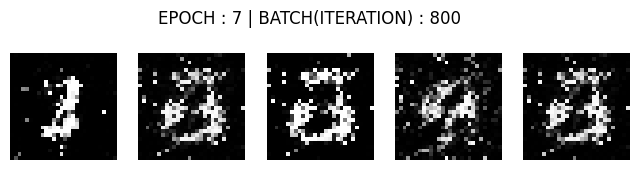

[Epoch: 7/10] [Batch: 938/938] [D loss: 0.273482] [G loss: 1.334578]


  0%|          | 0/938 [00:00<?, ?it/s]

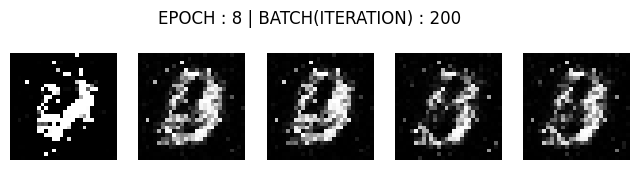

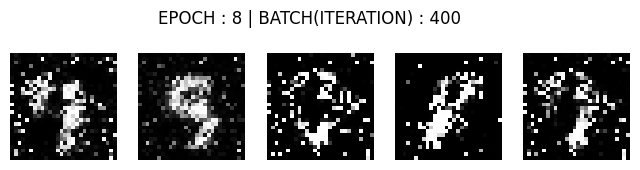

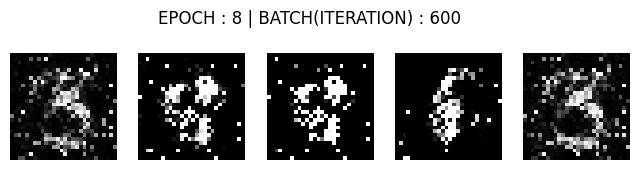

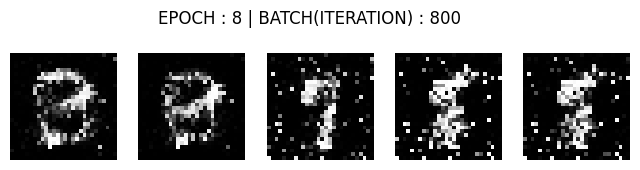

[Epoch: 8/10] [Batch: 938/938] [D loss: 0.251936] [G loss: 1.985578]


  0%|          | 0/938 [00:00<?, ?it/s]

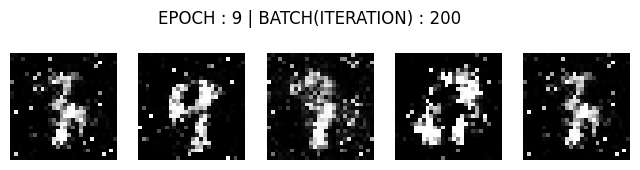

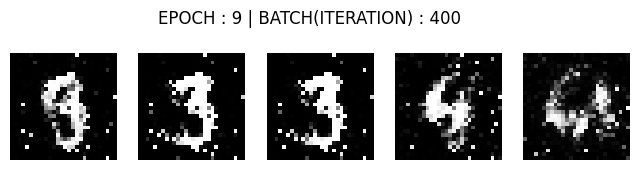

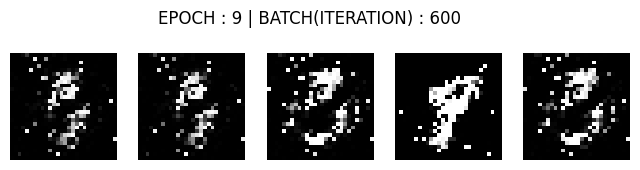

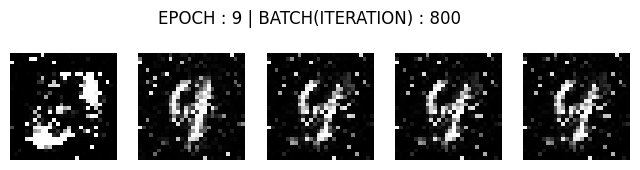

[Epoch: 9/10] [Batch: 938/938] [D loss: 0.110463] [G loss: 3.172015]


  0%|          | 0/938 [00:00<?, ?it/s]

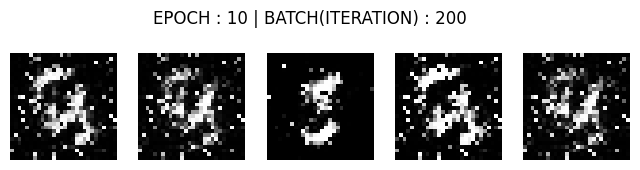

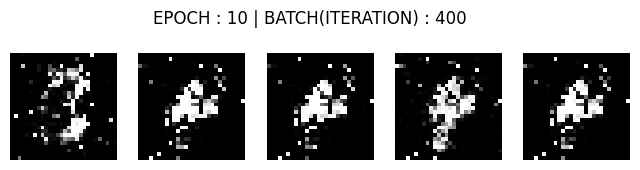

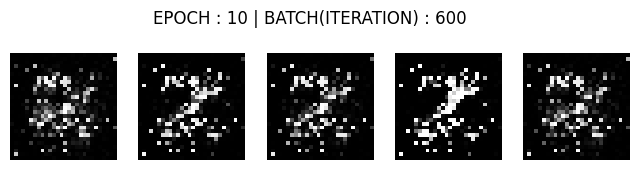

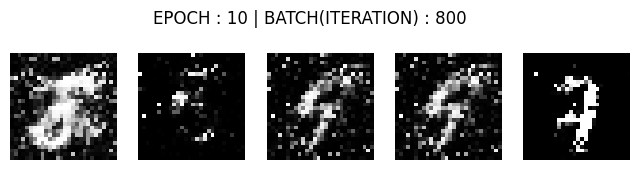

[Epoch: 10/10] [Batch: 938/938] [D loss: 0.145928] [G loss: 1.542607]


In [33]:
n_epochs = 10 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

In [34]:
# result of enumerate
count = 1
for i, (imgs,label) in enumerate(dataloader):
    print('Shape of Batch Images : \n', imgs.shape)
    print('Labels (1~64) : \n', label)
    print('-'*100)
    if count == 5:
        break
    else:
        count += 1

Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([4, 8, 2, 4, 0, 5, 3, 0, 2, 3, 9, 7, 1, 3, 3, 8, 4, 8, 0, 1, 4, 6, 4, 0,
        4, 6, 6, 9, 0, 7, 3, 2, 7, 8, 1, 1, 2, 4, 8, 3, 2, 8, 8, 3, 3, 1, 4, 2,
        2, 0, 3, 3, 4, 0, 6, 0, 5, 4, 1, 0, 9, 9, 9, 6])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([0, 9, 8, 9, 6, 9, 0, 4, 3, 9, 3, 9, 9, 2, 0, 8, 5, 0, 6, 1, 0, 6, 0, 3,
        0, 3, 2, 9, 4, 6, 9, 9, 9, 1, 9, 1, 5, 3, 5, 5, 7, 6, 5, 0, 2, 7, 7, 4,
        0, 0, 3, 8, 0, 9, 3, 5, 2, 1, 8, 7, 0, 4, 0, 9])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([8, 1, 8, 3, 3, 3, 5, 5, 5, 0, 1, 2, 8, 9, 0, 1, 0, 1, 5, 4, 5, 5, 7, 4,
        0, 3, 3, 6, 0, 3, 2, 1, 0, 2, 3, 7, 9, 2, 1, 3, 7, 4, 0, 9, 

> TEST CODE :
- Read CSV file
- Tensor(imgs.size(0),1)
- Tensor(imgs.size(0),1).fill_(1.0)

In [35]:
Tensor(10,1) # Just 10 for a quick look.
# We dealt with Tensor(imgs.size(0),1) above. Tensor(64,1) <-- len(H) == batch_size == 64, len(W) == 1

tensor([[-1.1111e-24],
        [ 4.5793e-41],
        [-3.6659e+19],
        [ 3.1306e-41],
        [ 4.4842e-44],
        [ 0.0000e+00],
        [ 1.7937e-43],
        [ 0.0000e+00],
        [-1.1408e-12],
        [ 3.1299e-41]])

In [37]:
Tensor(10,1).fill_(1.0) # _ means inplace, fill the Tensor with 1.0

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

> TEST CODE : Variable and requires_grad

> TEST CODE : Ramdom Sampling (H,W) from a normal(Gaussian) distribution

In [39]:
np.random.normal(0,1,(64,100))

array([[ 1.13278391,  1.28959145, -0.7242719 , ...,  0.95983838,
         0.28509601, -1.37809893],
       [ 0.53771579, -0.21506697, -0.16190062, ..., -0.35300439,
         0.04208585,  0.39085725],
       [-0.21282341,  2.02836297,  1.87216836, ..., -0.1735176 ,
         0.35813096, -0.28603907],
       ...,
       [ 0.42834132,  0.69263836, -0.51188124, ..., -0.22653062,
         0.40383838,  0.44421902],
       [-0.59853507,  0.24228074, -0.26935362, ..., -1.7754458 ,
         1.20546401, -0.63127576],
       [ 1.45368398,  0.77737346, -0.48680367, ...,  0.88136643,
         0.26453343,  0.90827339]])

In [40]:
np.random.normal(0,1,(64,100)).shape

(64, 100)

> TEST CODE : shape of z and gen_imgs and discriminator(gen_imgs)

In [41]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape

torch.Size([64, 100])

In [42]:
# generated images
sample_gen_imgs = generator(sample_z)
sample_gen_imgs.shape

torch.Size([64, 1, 28, 28])

In [43]:
# discrimination result
sample_discrim_result = discriminator(sample_gen_imgs)
sample_discrim_result.shape

torch.Size([64, 1])

> TEST CODE : g_loss

In [44]:
adversarial_loss

BCELoss()

In [45]:
sample_valid = Tensor(64,1).fill_(1.0)
sample_g_loss = adversarial_loss(sample_discrim_result, sample_valid)
sample_g_loss

tensor(4.0563, grad_fn=<BinaryCrossEntropyBackward0>)

In [48]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X.detach()**3

result = (square_X+cubic_X).sum()
result

tensor(1568., grad_fn=<SumBackward0>)

--------------